## Shear bands:

This notebook explores shear band emergence. The models are based on those described in  

Spiegelman, Marc, Dave A. May, and Cian R. Wilson. "On the solvability of incompressible Stokes with viscoplastic rheologies in geodynamics." Geochemistry, Geophysics, Geosystems (2016).
	
Kaus, Boris JP. "Factors that control the angle of shear bands in geodynamic numerical models of brittle deformation." Tectonophysics 484.1 (2010): 36-47.


Lemiale, V., et al. "Shear banding analysis of plastic models formulated for incompressible viscous flows." Physics of the Earth and Planetary Interiors 171.1 (2008): 177-186.


Moresi, L., and H-B. Mühlhaus. "Anisotropic viscous models of large-deformation Mohr–Coulomb failure." Philosophical Magazine 86.21-22 (2006): 3287-3305.
    
    
## Scaling

For this problem, 

* we scale velocities by $U_0$, the imposed boundary velocity  (m/s)
* viscosities by $10^{22}$ Pa s, and 
* stresses/pressures by $\eta_0 U_0/H$, where H is the layer depth (m). 

### NOTES

In [81]:
from __future__ import division
from dolfin import *
import math
import numpy as np
import sys
import os


#!sudo pip2.7 install easydict
from easydict import EasyDict as edict

%matplotlib inline

In [82]:
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

In [83]:
print(has_linear_algebra_backend("PETSc"), has_linear_algebra_backend("Tpetra"))
print(has_krylov_solver_preconditioner("amg"), has_krylov_solver_method("minres"))

(True, False)
(True, True)


In [84]:
############
#Model letter and number, output directory setup
############


#Model letter identifier default
Model = "T"

#Model number identifier default:
ModNum = 0

#Any isolated letter / integer command line args are interpreted as Model/ModelNum

if len(sys.argv) == 1:
    ModNum = ModNum 
elif sys.argv[1] == '-f': #
    ModNum = ModNum 
else:
    for farg in sys.argv[1:]:
        if not '=' in farg: #then Assume it's a not a paramter argument
            try:
                ModNum = int(farg) #try to convert everingthing to a float, else remains string
            except ValueError:
                Model  = farg


outputPath = "results" + "/" +  str(Model) + "/" + str(ModNum) + "/" 
imagePath = outputPath + 'images/'
filePath = outputPath + 'files/'
checkpointPath = outputPath + 'checkpoint/'
dbPath = outputPath + 'gldbs/'
outputFile = 'results_model' + Model + '_' + str(ModNum) + '.dat'

if rank==0:
    # make directories if they don't exist
    if not os.path.isdir(outputPath):
        os.makedirs(outputPath)
    if not os.path.isdir(checkpointPath):
        os.makedirs(checkpointPath)
    if not os.path.isdir(imagePath):
        os.makedirs(imagePath)
    if not os.path.isdir(dbPath):
        os.makedirs(dbPath)
    if not os.path.isdir(filePath):
        os.makedirs(filePath)

        
comm.Barrier() #Barrier here so no procs run the check in the next cell too early

In [85]:
###########
#Store the physical parameters, scale factors and dimensionless paramters in easyDicts
###########

#dp : dimensional paramters
dp = edict({})
dp.depth=30*1e3                #domain depth
dp.asthenosphere=dp.depth/4    #level from bottom of model,
dp.eta1=1e24
dp.eta2=1e20
dp.etaMin=1e18
dp.U0=0.0025/(3600*24*365)     #m/s 
dp.rho=2700.                   #kg/m3
dp.g=9.81
dp.cohesion=100e6              #
dp.fa=30.                      #friction angle degrees
dp.a=0.                        #fraction of the dynamic pressure to include in the yield function
dp.notchWidth = dp.depth/16.



#md : Modelling choices and Physics switches
md = edict({})        
md.refineMesh=False
md.stickyAir=False
md.aspectRatio=4.
md.res=32
md.ppc=25
md.tol=1e-10
md.maxIts=50
md.perturb=0 # 0 for material heterogeneity, 1 for cohesion weakening

###########
#If command line args are given, overwrite
#Note that this assumes that params as commans line args/
#only append to the 'dimensional' and 'model' dictionary (not the non-dimensional)
###########    


###########
#If extra arguments are provided to the script" eg:
### >>> uw.py 2 dp.arg1=1 dp.arg2=foo dp.arg3=3.0
###
###This would assign ModNum = 2, all other values go into the dp dictionary, under key names provided
###
###Two operators are searched for, = & *=
###
###If =, parameter is re-assigned to givn value
###If *=, parameter is multipled by given value
###
### >>> uw.py 2 dp.arg1=1 dp.arg2=foo dp.arg3*=3.0
###########

for farg in sys.argv[1:]:
    try:
        (dicitem,val) = farg.split("=") #Split on equals operator
        (dic,arg) = dicitem.split(".") #colon notation
        if '*=' in farg:
            (dicitem,val) = farg.split("*=") #If in-place multiplication, split on '*='
            (dic,arg) = dicitem.split(".")
            
        if val == 'True': 
            val = True
        elif val == 'False':     #First check if args are boolean
            val = False
        else:
            try:
                val = float(val) #next try to convert  to a float,
            except ValueError:
                pass             #otherwise leave as string
        #Update the dictionary
        if farg.startswith('dp'):
            if '*=' in farg:
                dp[arg] = dp[arg]*val #multiply parameter by given factor
            else:
                dp[arg] = val    #or reassign parameter by given value
        if farg.startswith('md'):
            if '*=' in farg:
                md[arg] = md[arg]*val #multiply parameter by given factor
            else:
                md[arg] = val    #or reassign parameter by given value
                
    except:
        pass
            

comm.barrier()

In [86]:
#In this code block we map the dimensional paramters to dimensionless, through scaling factors

#sf : scaling factors

sf = edict({})
sf.LS = 30*1e3
sf.eta0 = 1e22
sf.stress = (sf.eta0*dp.U0)/sf.LS
sf.vel = dp.U0
sf.density = sf.LS**3
sf.g = dp.g
sf.rho = (sf.eta0*dp.U0)/(sf.LS**2*dp.g)

#ndp : non dimensional parameters
ndp = edict({})
ndp.depth = dp.depth/sf.LS
ndp.U0 = dp.U0/sf.vel
ndp.asthenosphere = dp.asthenosphere/sf.LS
ndp.eta1 = dp.eta1/sf.eta0
ndp.eta2 = dp.eta2/sf.eta0
ndp.etaMin = dp.etaMin/sf.eta0
ndp.cohesion = (dp.cohesion/sf.stress)*np.cos(np.radians(dp.fa))
ndp.fa = math.sin(np.radians(dp.fa)) #friction coefficient
ndp.g = dp.g/sf.g
ndp.rho = dp.rho/sf.rho
ndp.notchWidth = dp.notchWidth/sf.LS
ndp.a = dp.a
            

In [87]:
# =============================================================================
# MESH
# =============================================================================

width, height = md.aspectRatio, ndp.depth # domain width and height
# option "crossed" stands for crossed diagonals (number of elements=XDIV*ZDIV*4)
mesh = RectangleMesh(Point(-width/2., 0), Point(width/2, height), int(md.res*md.aspectRatio), md.res, "crossed")
cell = triangle
norm = FacetNormal(mesh) # definition of an outer normal

ez = Constant((0, -1)) #gravity vector



In [88]:
#from mshr import *
#domain = Rectangle(dolfin.Point(-2., 0.), dolfin.Point(2., 1.))
#mesh = generate_mesh(domain,120)
#cell = triangle
#norm = FacetNormal(mesh) # definition of an outer normal

#ez = Constant((0, -1)) #gravity vector

In [89]:
#Try loading the refined mesh from speigelman

#mesh = Mesh("../plasticitymodels/mesh/compression_mesh_rounded_refine.xml.gz")
#coords = mesh.coordinates()
#coords[:,1] += 1.
#cell = triangle
#norm = FacetNormal(mesh) # definition of an outer normal

#ez = Constant((0, -1)) #gravity vector

In [90]:
# =============================================================================
# Mesh refine
# =============================================================================


if md.refineMesh:

    for i in [4.,2.]:
        center = Point(0.0, ndp.asthenosphere)
        radius = ndp.notchWidth * i

        # Mark cells for refinement
        markers = MeshFunction("bool", mesh, mesh.topology().dim())
        markers.set_all(False)
        for cell in cells(mesh):
            if (cell.midpoint().distance(center) < radius) and (cell.midpoint().y() > ndp.asthenosphere):
                markers[cell.index()] = True

        num_refinements = 1

        for i in range(num_refinements):

            # Refine mesh
            mesh = refine(mesh, markers)



center = 0.
sig = ndp.notchWidth


# Mark cells for refinement
markers = MeshFunction("bool", mesh, mesh.topology().dim())
markers.set_all(False)
for c in cells(mesh):
    x = c.midpoint().x()    
    fVal = ndp.notchWidth*math.exp(-1.*(x - center)**2/(2 * sig**2)) + ndp.asthenosphere
    
    if np.abs(fVal - c.midpoint().y()) < 0.01:
        markers[c] = True
    else:
        markers[c] = False


class MyExpression1(Expression):
    def eval(self, value, x):
        "Set value[0] to value at point x"
        value[0] = ndp.notchWidth*math.exp(-1.*(x[0] - center)**2.0/(2.0 * sig**2.0)) + ndp.asthenosphere


In [91]:
File('mesh.pvd') << mesh

In [92]:
#%pylab inline

#coords = mesh.coordinates()
#triplot(coords[:,0], coords[:,1], triangles=mesh.cells())
#print mesh.num_cells()

In [93]:
# =============================================================================
# Define function spaces
# =============================================================================

# Taylor-Hood elements: linear Lagrange elements for pressure
# and quadratic Lagrange elements for velocity


V = VectorElement("Lagrange", mesh.ufl_cell(), 2)
P = FiniteElement("Lagrange", mesh.ufl_cell(), 1)

TH = V * P
W = FunctionSpace(mesh, TH)

In [94]:
# Define variational problem

(u , p) = TrialFunctions(W)


(v , q)= TestFunctions(W)



In [95]:
# =============================================================================
# INITIAL CONDITIONS - & Material distribution
# =============================================================================
u_init = Expression(("0", "0","0"), degree=2) # zero


#Pressure  split. zero density in Stokes, 
density=Constant(0.)

class lithPressureFn(Expression):
    def eval(self, value, x):
        value[0] = ndp.rho* (1. - x[1])

In [96]:
lithPressure = lithPressureFn(degree=1)

In [97]:
# =============================================================================
# BOUNDARY CONDITIONS
# =============================================================================

# Define boundaries
def left(x):
    return near(x[0], -2)

def right(x):
    return near(x[0], 2)


def bottom(x):
    return near(x[1], 0)

def top(x):
    return near(x[1], 1)


noslip = Constant((0, 0))
freeslip = Constant(0)
leftBC = Constant((1.0, 0))
rightBC = Constant((-1.0, 0))

#W.sub(1) ~ Pressure DoFs
#W.sub(0) ~ Vel DoFs


bc_v_bot = DirichletBC(W.sub(0).sub(1), freeslip, bottom)
bc_v_left = DirichletBC(W.sub(0), leftBC, left)
bc_v_right = DirichletBC(W.sub(0), rightBC,right)


# fixing the pressure at the top boundary

bc_p = DirichletBC(W.sub(1),
                    Expression("0", degree=1),
                    "near(x[0],0) && near(x[1],0)",
                    method="pointwise")


# collection of BCs for mechanical part of the problem
bcs_W = [bc_p, bc_v_bot, bc_v_left, bc_v_right]

In [98]:
# =============================================================================
# Rheology
# =============================================================================


class Eta(Expression):
    def set_eta_values(self, eta_1, eta_2):
        self.eta_1, self.eta_2 = eta_1, eta_2
    def eval(self, value, x):
        "Set value[0] to value at point x"
        
        #circle1 = np.dot(x[0] - cCentre[0], x[0] - cCentre[0]) +   np.dot( x[1] - cCentre[1], x[1] - cCentre[1])
        mu = ndp.notchWidth
        sig =  0.25*ndp.notchWidth
        gausFn1 = ndp.notchWidth*math.exp(-1.*(x[0] - mu)**2/(2 * sig**2)) + ndp.asthenosphere

        gausFn2 = ndp.notchWidth*math.exp(-1.*(x[0] + mu)**2/(2 * sig**2)) + ndp.asthenosphere
        
        if (x[1] <= ndp.asthenosphere):
            value[0] = self.eta_2
        
        elif (x[1] <= ndp.asthenosphere + ndp.notchWidth) and (x[0] < ndp.notchWidth) and (x[0] > -1.*ndp.notchWidth):
            value[0] = self.eta_2
        
        elif x[1] <= gausFn1:
            value[0] = self.eta_2
        elif x[1] <= gausFn2:
            value[0] = self.eta_2

        else:
            value[0] = self.eta_1
    
            
            
# Initialize Eta - viscosity
etaExpr = Eta(degree=1)
etaExpr.set_eta_values(ndp.eta1, ndp.eta2)
etaExpr.eta_1, etaExpr.eta_2

(100.0, 0.01)

In [99]:
def eijeij(u):
    """calculate second invariant of the strainrate tensor"""
    return sqrt(0.5*(inner(sym(nabla_grad(u)), sym(nabla_grad(u)))))

def viscosity(w):
    
    u, p = w.split()
    
    viscosityl = ndp.eta1
    
    yStress = ndp.cohesion + ndp.fa*(lithPressure + ndp.a*p ) 
    
    viscosityp =  yStress/(2.*(eijeij(u) + 1e-10))
    return 1./(1./etaExpr + 1./viscosityp)
 
    
#our viscosity function will return a Fenics /UFl Exprssion
#the expression must be projected to a finite element space before we can visualize it:    


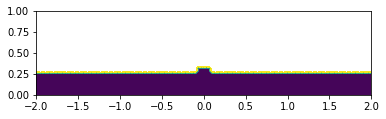

In [100]:
# =============================================================================
# Plotting expressions
# =============================================================================


X = FunctionSpace(mesh, P)

f = Function(X)
f.interpolate(etaExpr)
plot(f )

In [101]:
File('visc.pvd') << f

In [102]:
# =============================================================================
# Functions to solve
# =============================================================================

w = Function(W)


u_k = Function(W)
u_k.interpolate(u_init)



u_t = Function(W) #function to test different solutions


#some function spaces to project expressions on
V1 = FunctionSpace(mesh, 'P', 1)
V2 = FunctionSpace(mesh, 'P', 2)

In [103]:
# =============================================================================
# Picard loop
# =============================================================================

#import numpy as np

#w = Function(W)
#u_k = Function(W)  
#u_k.interpolate(u_init)
tol = 0.0001
maxIts = 2

for i in range(maxIts):
    
    #a = 2.*viscosity(u_k)*inner(grad(v), grad(omega))*dx \
    #- p*div(omega)*dx \
    #+ div(v)*phi*dx
    
    
    #bv = (inner(sym(grad(v_t)), 2.*eta_n*sym(grad(v_a))) - div(v_t)*p_a - inner(v_t,f_i)/L2h2)
    #bp = -p_t*div(v_a)

    
    bv = (inner(sym(grad(v)), 2.*viscosity(u_k)*sym(grad(u))) - div(v)*p)
    bp = -q*div(u)
    rv = bv*dx
    rp = bp*dx

    a = rv + rp

    L = density*inner(ez, v)*dx

    solve(a == L, w, bcs_W)

    diff = w.vector().array() - u_k.vector().array()
    eps = np.linalg.norm(diff, ord=np.Inf)
    
    vL2 = np.linalg.norm(w.vector().array(), ord=np.Inf)
    eps2 = eps/vL2
    
    #Non linear residual?
    test = assemble(action(a, w) - L)
    #test.array()
    res = np.linalg.norm(test.array(), ord=np.Inf)
    
    
    print (eps, eps2, res)

    u_k.assign(w)
    
    if eps2 < tol:
        break


(668.06529789297554, 1.0, 9.7605349539149362)
(657.25313530448454, 19.231537588065631, 0.56146171511256615)


In [104]:
current = w.copy()

In [105]:
u, p = w.split(deepcopy=True) 

In [106]:
print("Norm of velocity coefficient vector: %.15g" % u.vector().norm("l2"))
print("Norm of pressure coefficient vector: %.15g" % p.vector().norm("l2"))

Norm of velocity coefficient vector: 142.531985173635
Norm of pressure coefficient vector: 706.703832381586


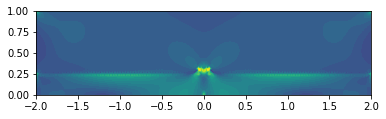

In [107]:

eij =  sqrt(0.5*(inner(sym(nabla_grad(u)), sym(nabla_grad(u)))))
eijFEM = project(eij , V1)
plot(eij , interactive=True, scalarbar = True ) 

In [108]:
File('u.pvd') << u
File('p.pvd') << p
File('eij.pvd') << eijFEM

In [109]:
# =============================================================================
# Newton loop
# =============================================================================


# Define solution functions - current solution
w = Function(W)
u, p = split(w)


bv = (inner(sym(grad(v)), 2.*viscosity(w)*sym(grad(u))) - div(v)*p - density*inner(ez, v))
#bv = (inner(sym(grad(v)), 2.*viscosity(w)*sym(grad(u))) - div(v)*p)
bp = -q*div(u)

rv = bv*dx
rp = bp*dx
F = rv + rp

J_W = derivative(F, w)
# create nonlinear problem
problem_W = NonlinearVariationalProblem(F, w, bcs_W, J_W)
solver_W = NonlinearVariationalSolver(problem_W)
solver_W.parameters['newton_solver']['krylov_solver']['monitor_convergence'] = True
solver_W.parameters['newton_solver']['krylov_solver']['report'] = True

prm = solver_W.parameters
# Newton solver parameters (mechanical part of the problem)
prm["newton_solver"]["relative_tolerance"] = 1E-7
#prm["newton_solver"]["absolute_tolerance"] = 1E-11
prm["newton_solver"]["maximum_iterations"] = 2
prm["newton_solver"]["relaxation_parameter"] = 1.0
#prm["newton_solver"]["convergence_criterion"] = 'incremental'
prm["newton_solver"]["convergence_criterion"] = "residual"
prm["newton_solver"]["linear_solver"] = "mumps"
set_log_level(PROGRESS)
#set_log_level(DBG)

In [110]:
# initializing velocity-pressure from the Picard solution 
w.interpolate(current)


In [127]:
#Some options to set an iterative Krylov method instead if direct, none of this tested, just here for future
#https://github.com/MiroK/fenics-qa/blob/master/test121.py



#prec = "amg" if has_krylov_solver_preconditioner("amg") else "default"
#prec = 'jacobi' if 'jacobi' in zip(*krylov_solver_preconditioners())[0] else 'ilu'


#prm['newton_solver']['linear_solver'] = 'gmres'
#prm['newton_solver']['preconditioner'] = prec
#prm['newton_solver']['krylov_solver']['absolute_tolerance'] = 1E-9
#prm['newton_solver']['krylov_solver']['relative_tolerance'] = 1E-7
#prm['newton_solver']['krylov_solver']['maximum_iterations'] = 1000
#prm['newton_solver']['krylov_solver']['monitor_convergence'] = True
#prm['newton_solver']['krylov_solver']['nonzero_initial_guess'] = False


In [116]:
#info("Solve momentum equation")
solver_W.solve()

RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to solve nonlinear system with NewtonSolver.
*** Reason:  Newton solver did not converge because maximum number of iterations reached.
*** Where:   This error was encountered inside NewtonSolver.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2016.2.0
*** Git changeset:  0f003bc07ee5fd583fb956245016d5972b80fea1
*** -------------------------------------------------------------------------


In [117]:
#test = 
#solver_W.parameters['newton_solver']['krylov_solver']['monitor_convergence']
#solver_W.__

In [118]:
#prm_W['newton_solver']['krylov_solver']['absolute_tolerance']

In [119]:
# =============================================================================
# Non linear residual
# =============================================================================

b = assemble(F)    # Residual
x = w.vector()

for bc in bcs_W:
    bc.apply(b, x)
        
res_norm = b.norm('l2')

# Log output
print(res_norm)

nan


In [120]:
# =============================================================================
# Figures tc
# =============================================================================

In [121]:
u, p = w.split(deepcopy=True) 

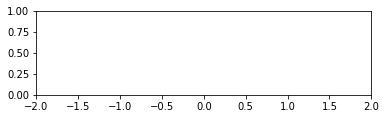

In [122]:
eij =  sqrt(0.5*(inner(sym(nabla_grad(u)), sym(nabla_grad(u)))))
eijFEM = project(eij , V1)
plot(eij , interactive=True, scalarbar = True ) 

In [72]:
File('u.pvd') << u
File('p.pvd') << p
File('eij.pvd') << eijFEM

uvals = eijFEM.vector().array()
xyvals = mesh.coordinates()
#xyvals = dofs_x
xvals = xyvals[:,0]
yvals= xyvals[:,1]

xx = np.linspace(-2,2, 100)
yy = np.linspace(0,1, 25)

XX, YY = np.meshgrid(xx,yy)


from scipy.interpolate import griddata
uu = griddata(np.column_stack((xvals, yvals)), uvals, np.dstack((XX, XX)))

uvals = eijFEM.vector().array()
xyvals = mesh.coordinates()
#xyvals = dofs_x
xvals = xyvals[:,0]
yvals= xyvals[:,1]

xx = np.linspace(-2,2, 100)
yy = np.linspace(0,1, 25)

XX, YY = np.meshgrid(xx,yy)


In [73]:
#
dolfin.fem.bcs.homogenize(bc)

AttributeError: 'module' object has no attribute 'homogenize'

## Find shear band angle

In [33]:
#only in serial


## stash

In [31]:
# =============================================================================
# Quasi-Newton loop
# =============================================================================


# Define solution functions - current solution
w = Function(W)
u, p = split(w)


# These are for the approximate Jacobian
w_a = Function(W)
u_a, p_a = split(w_a)


bv = (inner(sym(grad(v)), 2.*viscosity(w)*sym(grad(u))) - div(v)*p - density*inner(ez, v))
#bv = (inner(sym(grad(v)), 2.*viscosity(w)*sym(grad(u))) - div(v)*p)
bp = -q*div(u)

rv = bv*dx
rp = bp*dx
F = rv + rp

bJv = (inner(sym(grad(v)), 2.*viscosity(w_a)*sym(grad(u_a))) - div(v)*p_a )
bJp = -q*div(u_a)

Jv = bJv*dx
Jp = bJp*dx

J_W = Jv + Jp


#J_W = derivative(F, w)
# create nonlinear problem
problem_W = NonlinearVariationalProblem(F, w, bcs_W, J_W)
solver_W = NonlinearVariationalSolver(problem_W)
prm_W = solver_W.parameters
# Newton solver parameters (mechanical part of the problem)
prm_W["newton_solver"]["relative_tolerance"] = 1E-7
#prm_W["newton_solver"]["absolute_tolerance"] = 1E-11
prm_W["newton_solver"]["maximum_iterations"] = 10
prm_W["newton_solver"]["relaxation_parameter"] = 1.0
#prm_W["newton_solver"]["convergence_criterion"] = 'incremental'
prm_W["newton_solver"]["convergence_criterion"] = "residual"
prm_W["newton_solver"]["linear_solver"] = "mumps"
set_log_level(PROGRESS)

RuntimeError: 

*** -------------------------------------------------------------------------
*** DOLFIN encountered an error. If you are not able to resolve this issue
*** using the information listed below, you can ask for help at
***
***     fenics-support@googlegroups.com
***
*** Remember to include the error message listed below and, if possible,
*** include a *minimal* running example to reproduce the error.
***
*** -------------------------------------------------------------------------
*** Error:   Unable to define nonlinear variational problem F(u; v) = 0 for all v.
*** Reason:  Expecting the Jacobian J to be a bilinear form (not rank 1).
*** Where:   This error was encountered inside NonlinearVariationalProblem.cpp.
*** Process: 0
*** 
*** DOLFIN version: 2016.2.0
*** Git changeset:  0f003bc07ee5fd583fb956245016d5972b80fea1
*** -------------------------------------------------------------------------
